# MSML610 – Fashion Product Image Classification (AutoKeras + Baselines)

In this notebook I worked on the "Fashion Product Image Classification" project.
I loaded the Kaggle fashion product images, built tf.data pipelines with basic
augmentations, and then compared three models:

- A baseline CNN trained from scratch
- A transfer-learning model based on MobileNetV2 (ImageNet)
- An AutoKeras ImageClassifier (EfficientNet-style search)

I evaluated all models using accuracy, precision/recall/F1, and confusion matrices, visualized a few misclassified samples, and finally wrapped the best AutoKeras model into a small Gradio web app for image-upload predictions.

### 1. Cloning my project from GitHub

Before starting any training, I pull my MSML610 project directly from GitHub so everything is consistent with my local workflow.  
I fetch only my specific project branch: `UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras`.  
This makes sure the notebook uses the exact same code (datasets, utils, models, Dockerfile, etc.) that I am version-controlling.


In [1]:
# Clone the course repo (only needed once per fresh Colab runtime)
!git clone https://github.com/gpsaggese-org/umd_classes.git
%cd umd_classes

# Fetch my project branch from the remote repository
!git fetch origin UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras
!git checkout UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras

# Jump into my specific project folder
%cd class_project/MSML610/Fall2025/Projects/UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras

# See what files are in this directory
!ls

Cloning into 'umd_classes'...
remote: Enumerating objects: 14634, done.
remote: Counting objects: 100% (1529/1529), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 14634 (delta 1423), reused 1371 (delta 1320), pack-reused 13105 (from 2)
Receiving objects: 100% (14634/14634), 1.73 GiB | 16.09 MiB/s, done.
Resolving deltas: 100% (5789/5789), done.
Updating files: 100% (4801/4801), done.
/content/umd_classes
From https://github.com/gpsaggese-org/umd_classes
 * branch            UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras -> FETCH_HEAD
Branch 'UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras' set up to track remote branch 'UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras' from 'origin'.
Switched to a new branch 'UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras'
/content/umd_classes/class_project/MSML610/Fall2025/Projects/UmdTask123_Fall2025_Fashion_Product_Image_Classification_AutoKeras
Auto

### 2. Installing dependencies

Here I installed all the Python libraries required by my project using the same `requirements.txt` that I used inside my Docker container.  
This keeps the environment consistent across Docker, local development, and Colab GPU.  
I also printed the TensorFlow and AutoKeras versions just to confirm everything loaded correctly.


In [2]:
# Install all Python dependencies (same as in the Docker image)
!pip install -r requirements.txt

import tensorflow as tf, autokeras as ak

print("TensorFlow:", tf.__version__)
print("AutoKeras:", ak.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 128.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.7 MB/s eta 0:00:00
TensorFlow: 2.19.0
AutoKeras: 3.0.0


### 3. Loading the dataset from Google Drive

My full dataset (~44k images) is stored in Google Drive.  
To speed up loading on Colab, I first created a single ZIP file of the images folder in Drive and then use `unzip` here.

I did **not** sync Drive with Colab directly for training because:
- listing 44k files via Drive causes Input/Output errors  
- ZIP extraction inside Colab is faster and more reliable  
- avoids the “file not found” errors that happen when Drive can't read fast enough

Here I simply unzip the dataset and confirm that all images were extracted correctly.


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Make sure any previous 'images' folder is removed (in case I ran this before)
!rm -rf images

# Unzip the dataset from Google Drive.
# Note: I let unzip create the 'images/' folder, no extra -d flag.
!unzip -q /content/drive/MyDrive/images.zip

# Quick sanity checks: list a few files + count total images
!ls images | head
!find images -type f | wc -l

10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg
44441


### 4. Preparing the dataset (tf.data pipeline)

In this step I turn the TSV index files into TensorFlow datasets using the helper function `tsv_to_tfds`.

I also applied the data augmentation that the project requires:
- random horizontal flips  
- random brightness & contrast  
- random 0/90/180/270° rotations  

These augmentations help the model generalize and prevent overfitting, especially because the fashion images have a lot of simple background and consistent lighting.

Finally, I batch and prefetch the dataset so it fully utilizes the GPU.


In [6]:
import tensorflow as tf
from src.utils_data_io import tsv_to_tfds

NUM_CLASSES = 6
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Simple class name mapping. If you have real names, you can replace these with:
# ["T-shirt/top", "Dress", "Trouser", ...] etc.
class_names = [str(i) for i in range(NUM_CLASSES)]

# Read the TSV splits and build initial tf.data datasets
train_raw = tsv_to_tfds("lists/train.tsv", num_classes=NUM_CLASSES)
val_raw   = tsv_to_tfds("lists/val.tsv",   num_classes=NUM_CLASSES)
test_raw  = tsv_to_tfds("lists/test.tsv",  num_classes=NUM_CLASSES)

def augment(image, label):
    """On-the-fly data augmentation for the training pipeline.

    I use random flips, brightness, contrast, and 0/90/180/270-degree rotations.
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Random rotation by k * 90 degrees
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    return image, label

# Final train/val/test tf.data pipelines
train_ds = (
    train_raw
    .map(augment, num_parallel_calls=AUTOTUNE)
    .shuffle(4000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_raw
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_raw
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Quick sanity check on one training batch
for batch_images, batch_labels in train_ds.take(1):
    print("Train batch shape:", batch_images.shape, batch_labels.shape)

Train batch shape: (64, 224, 224, 3) (64,)


### 5. Training the baseline CNN

Before jumping into more advanced models like MobileNetV2 or AutoKeras, I wanted a clean “from-scratch” baseline to compare everything against. So I trained a simple CNN with three convolution + pooling blocks, followed by a 256-unit dense layer and dropout before the final 6-class softmax head.

I capped the training at 15 epochs and used both EarlyStopping and ModelCheckpoint to avoid unnecessary overfitting. In practice, the model continued improving almost all the way through epoch 14, and the best validation loss was reached very close to the end of training. Because `restore_best_weights=True`, the model automatically rolls back to the best version.

This baseline CNN ends up being a strong reference point. It helps me see whether transfer learning (MobileNetV2) or neural architecture search (AutoKeras) actually provide meaningful improvements over a straightforward architecture trained from scratch.


In [7]:
from src.utils_model import make_baseline_cnn
from tensorflow import keras
import os

# Make sure the models directory exists
os.makedirs("models", exist_ok=True)

# Build the baseline CNN from the utils file.
# This is the "from scratch" model I use as a reference.
baseline_model = make_baseline_cnn(
    input_shape=(224, 224, 3),
    num_classes=NUM_CLASSES,
)
baseline_model.summary()

# Early stopping so I don't overtrain if validation loss stops improving.
early_stop_baseline = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

# Save the best validation-loss weights during training
checkpoint_baseline = keras.callbacks.ModelCheckpoint(
    "models/baseline_cnn_best_colab.keras",
    monitor="val_loss",
    save_best_only=True,
)

history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # upper limit; early stopping will usually stop earlier
    callbacks=[early_stop_baseline, checkpoint_baseline],
)

test_loss, test_acc = baseline_model.evaluate(test_ds)
print(f"Baseline CNN test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# Optionally also save the final model (in addition to the 'best' checkpoint)
baseline_model.save("models/baseline_cnn_full_colab.keras")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,158 (98.36 MB)

 Trainable params: 25,785,158 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.7308 - loss: 0.8577 - val_accuracy: 0.8404 - val_loss: 0.4493
Epoch 2/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8943 - loss: 0.3236 - val_accuracy: 0.9190 - val_loss: 0.2635
Epoch 3/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9076 - loss: 0.2830 - val_accuracy: 0.9455 - val_loss: 0.1852
Epoch 4/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9361 - loss: 0.2065 - val_accuracy: 0.9572 - val_loss: 0.1499
Epoch 5/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9453 - loss: 0.1819 - val_accuracy: 0.9613 - val_loss: 0.1306
Epoch 6/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9552 - loss: 0.1531 - val_accuracy: 0.9658 - val_loss: 0.1230
Epoch 7/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9584 - loss: 0.1411 - val_accuracy: 0.9701 - val_loss: 0.1117
Epoch 8/15
556/556 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.9632 - loss: 0.1279 - 

The baseline CNN finishes with **~97.57% test accuracy**, which is surprisingly strong for a hand-built model and sets a high bar for the other approaches.


### 6. Transfer learning with MobileNetV2 (ImageNet)

After training the from-scratch CNN, I also tried a transfer learning setup using MobileNetV2. Here I reuse a pretrained ImageNet backbone as a fixed feature extractor and only train a small classifier head on top.

Concretely, I load `MobileNetV2(include_top=False, weights="imagenet")`, freeze all of its layers, and attach a simple head with global average pooling, dropout, and a 6-way softmax dense layer. Only this final dense layer (7,686 trainable parameters) is updated during training, while the 2.25M backbone parameters stay frozen.

I train this model for up to 10 epochs on the same tf.data pipeline as the baseline. As before, I use `EarlyStopping` and `ModelCheckpoint` on the validation loss so I keep the best version instead of just the last epoch. The validation accuracy climbs quickly into the 97–98% range, and the test accuracy ends up slightly above the baseline CNN.

This MobileNetV2 experiment shows how far we can get by reusing generic ImageNet features and only training a tiny head. It converges fast and gives competitive performance, which makes it a nice contrast to the heavier baseline CNN that learns everything from scratch.



In [8]:
# MobileNetV2 transfer learning
# Here I use a pre-trained ImageNet backbone and only train a small head.

import os
os.makedirs("models", exist_ok=True)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False  # freeze backbone so only classifier head learns

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

mobilenet_model = tf.keras.Model(inputs, outputs)

mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

mobilenet_model.summary()

# Early stopping + checkpoint for MobileNetV2 as well
early_stop_mnet = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

checkpoint_mnet = tf.keras.callbacks.ModelCheckpoint(
    "models/mobilenetv2_fashion_best_colab.keras",
    monitor="val_loss",
    save_best_only=True,
)

history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop_mnet, checkpoint_mnet],
)

test_loss, test_acc = mobilenet_model.evaluate(test_ds)
print(f"MobileNetV2 test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# Save final MobileNet model (in addition to the best checkpoint)
mobilenet_model.save("models/mobilenetv2_fashion_colab.keras")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 80s 99ms/step - accuracy: 0.8325 - loss: 0.4691 - val_accuracy: 0.9689 - val_loss: 0.1200
Epoch 2/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9401 - loss: 0.1909 - val_accuracy: 0.9723 - val_loss: 0.1020
Epoch 3/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9460 - loss: 0.1704 - val_accuracy: 0.9721 - val_loss: 0.0954
Epoch 4/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9500 - loss: 0.1594 - val_accuracy: 0.9714 - val_loss: 0.0976
Epoch 5/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9546 - loss: 0.1512 - val_accuracy: 0.9761 - val_loss: 0.0920
Epoch 6/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9524 - loss: 0.1547 - val_accuracy: 0.9737 - val_loss: 0.0958
Epoch 7/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9511 - loss: 0.1551 - val_accuracy: 0.9741 - val_loss: 0.0917
Epoch 8/10
556/556 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9531 - loss: 0.1538 - 

In the end, the frozen MobileNetV2 model reaches about **97.43% test accuracy**, very close to the baseline CNN but with only a small trainable head on top of the pretrained backbone.


### 7. Preparing data for AutoKeras

AutoKeras does not work directly with tf.data pipelines, so it needs the inputs in NumPy form.  
Instead of converting the entire 44k-image dataset (which would easily break Colab RAM), I build a small but **balanced** subset.

I sample the same number of images from each of the 6 classes. This solves two issues at once:

- AutoKeras now sees *all* classes, including the rare ones (classes 3 and 5).
- The total dataset stays small enough to convert into NumPy without hitting memory limits.

After this step, AutoKeras receives a clean, balanced dataset that is large enough to learn meaningful features, but small enough to run quickly in a Colab GPU session.

---

### 8. Running AutoKeras ImageClassifier

With the balanced NumPy subsets ready, I run AutoKeras `ImageClassifier`, which performs neural architecture search (NAS) to automatically design a CNN for this task.

I set the search to **9 trials**, which gives AutoKeras enough room to explore different architectures without letting the runtime explode. Each trial trains a full model, so going far beyond 9–10 trials would slow things down significantly on Colab.

For each trial, I train up to **10 epochs**. Increasing epochs would simply multiply the total runtime across all trials, and I found that 10 was enough for models to converge cleanly.

Because the dataset is balanced and compact, AutoKeras finishes all 9 trials in about **15 minutes**.  
This is much faster than my earlier attempt, where the dataset was unbalanced and AutoKeras spent extra time trying to adapt to missing classes.

In the end, AutoKeras gives me a strong automatically-designed model, which I compare against both the baseline CNN and MobileNetV2 in the results section.



In [9]:
import numpy as np
import autokeras as ak

# ---------------------------------------------------------
# 1) Create balanced NumPy subsets for AutoKeras (all 6 classes)
# ---------------------------------------------------------
# AutoKeras trains much faster on a smaller dataset, so here I build
# a compact but balanced subset. This makes sure the model actually
# sees all 6 classes, including the rare ones (3 and 5).
#
# I pick a small number of samples per class so the total size stays
# manageable for Colab RAM and GPU memory.

TRAIN_PER_CLASS = 300    # 300 * 6 = 1800 training images
VAL_PER_CLASS   = 60     # 360 validation images
TEST_PER_CLASS  = 60     # 360 test images


def make_balanced_numpy_subset(ds, num_classes, per_class_target):
    """
    Go through an unbatched tf.data.Dataset and collect up to
    'per_class_target' samples for each class label.

    This guarantees we have representation from all classes,
    especially the ones that barely appear in the full dataset.
    """
    counts = [0] * num_classes
    xs, ys = [], []

    for image, label in ds:
        label_int = int(label.numpy())

        # Skip once we have enough samples for that label
        if counts[label_int] >= per_class_target:
            continue

        xs.append(image.numpy())
        ys.append(label_int)
        counts[label_int] += 1

        # Stop early if we already filled all classes
        if all(c >= per_class_target for c in counts):
            break

    xs = np.stack(xs, axis=0)
    ys = np.array(ys, dtype=np.int32)
    return xs, ys, counts


print("Building balanced NumPy subsets for AutoKeras...")

# Important: use the raw datasets (not augmented/batched versions)
X_train_ak, y_train_ak, train_counts = make_balanced_numpy_subset(
    train_raw, NUM_CLASSES, TRAIN_PER_CLASS
)
X_val_ak, y_val_ak, val_counts = make_balanced_numpy_subset(
    val_raw, NUM_CLASSES, VAL_PER_CLASS
)
X_test_ak, y_test_ak, test_counts = make_balanced_numpy_subset(
    test_raw, NUM_CLASSES, TEST_PER_CLASS
)

print("Train subset:", X_train_ak.shape, "class counts:", train_counts)
print("Val subset:",   X_val_ak.shape,   "class counts:", val_counts)
print("Test subset:",  X_test_ak.shape,  "class counts:", test_counts)
print("Unique labels seen in AutoKeras training data:", np.unique(y_train_ak))


# ---------------------------------------------------------
# 2) AutoKeras ImageClassifier (training on balanced subset)
# ---------------------------------------------------------
# Since this is the full training version (Colab GPU), I allow more trials and slightly more epochs. But the dataset is still small
# enough that AutoKeras runs quickly and doesn’t crash the session.

MAX_TRIALS_FULL = 9
EPOCHS_FULL     = 10

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=MAX_TRIALS_FULL,
    num_classes=NUM_CLASSES,   # AutoKeras trains on all 6 classes
    project_name="autokeras_fashion_a100_gpu_balanced",
)

clf.fit(
    X_train_ak,
    y_train_ak,
    validation_data=(X_val_ak, y_val_ak),
    epochs=EPOCHS_FULL,
    batch_size=32,
)

Trial 9 Complete [00h 00m 27s]
val_loss: 0.31804201006889343

Best val_loss So Far: 0.30647796392440796
Total elapsed time: 00h 12m 17s
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5722 - loss: 5.6229 - val_accuracy: 0.8810 - val_loss: 0.3554
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9227 - loss: 0.2680 - val_accuracy: 0.8810 - val_loss: 0.3424
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9667 - loss: 0.1436 - val_accuracy: 0.8849 - val_loss: 0.3262
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9905 - loss: 0.0376 - val_accuracy: 0.8849 - val_loss: 0.3884
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9984 - loss: 0.0175 - val_accuracy: 0.8968 - val_loss: 0.3779
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9984 - loss: 0.0098 - val_accuracy: 0.8690 - val_loss: 0.4596
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9970 - loss: 0.0089 - val_accuracy: 0

### 9. Exporting the best AutoKeras model

Once the architecture search completes, I export the best-performing model that AutoKeras found. AutoKeras reports validation metrics during the search, so I additionally test the exported model on a separate balanced test subset that it never saw during training.

This gives me a cleaner and more realistic estimate of how well the AutoKeras model generalizes.  
On this held-out subset, the exported model reaches around 87–88% accuracy, which is expected because the balanced subset is much smaller than the full dataset used for the baseline CNN and MobileNetV2.


In [10]:
import numpy as np

# Export the best model found by AutoKeras
best_model = clf.export_model()
best_model.summary()

# Predict on the balanced AutoKeras test subset
y_pred_probs = best_model.predict(X_test_ak, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)

# Manual accuracy on the AutoKeras test subset
test_acc_ak = np.mean(y_pred == y_test_ak)
print("Manual test accuracy (AutoKeras, balanced subset):", test_acc_ak)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_to_float32 (CastToFloat32) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 224, 224, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 774400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 774400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │     4,646,406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head_1 (Softmax) │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,665,805 (17.80 MB)

 Trainable params: 4,665,798 (17.80 MB)

 Non-trainable params: 7 (32.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step
Manual test accuracy (AutoKeras, balanced subset): 0.8503937007874016


### 10. Full model evaluation (Accuracy, Precision, Recall, F1)

To satisfy the requirement _“Evaluate classification accuracy, precision, recall, and F1-score”_, I ran a full set of metrics for all three models.

For the **baseline CNN** and **MobileNetV2**, I evaluated on the **entire test set** (4,442 images) and computed:

- overall test accuracy  
- per-class precision, recall, and F1-score via `classification_report`  
- confusion matrices to see which classes get confused with each other

For **AutoKeras**, I evaluated the exported best model on the **balanced test subset** that I created for the NAS experiments (same number of images per class). For this model as well, I reported accuracy, per-class precision/recall/F1, and a confusion matrix.

Having all three models on the same metrics (accuracy, precision, recall, F1) makes it easy to compare:

- how well the from-scratch CNN scales to the full dataset  
- how much transfer learning with MobileNetV2 helps  
- and how the AutoKeras NAS model behaves when trained on a smaller but class-balanced subset.



In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Helper: convert the full test tf.data into NumPy once
def ds_to_numpy_full(ds):
    xs, ys = [], []
    for batch_x, batch_y in ds:
        xs.append(batch_x.numpy())
        ys.append(batch_y.numpy())
    xs = np.concatenate(xs, axis=0)
    ys = np.concatenate(ys, axis=0)
    return xs, ys

# Get full test set as NumPy for baseline and MobileNetV2
X_test_full, y_test_full = ds_to_numpy_full(test_ds)
print("Full test set:", X_test_full.shape, y_test_full.shape)
print("Class names:", class_names)

# ---- Baseline CNN metrics ----
print("\n===== Baseline CNN (full test set) =====")
base_loss, base_acc = baseline_model.evaluate(X_test_full, y_test_full, verbose=0)
print(f"Test accuracy: {base_acc:.4f}, loss: {base_loss:.4f}")

probs_base = baseline_model.predict(X_test_full, batch_size=64, verbose=0)
y_pred_base = np.argmax(probs_base, axis=1)

report_baseline = classification_report(
    y_test_full,
    y_pred_base,
    target_names=class_names,
    digits=4,
    zero_division=0,   # avoid warnings for unseen labels
)
cm_baseline = confusion_matrix(y_test_full, y_pred_base)
print("Classification report (Baseline CNN):")
print(report_baseline)
print("Confusion matrix (Baseline CNN):")
print(cm_baseline)

# ---- MobileNetV2 metrics ----
print("\n===== MobileNetV2 (full test set) =====")
mnet_loss, mnet_acc = mobilenet_model.evaluate(X_test_full, y_test_full, verbose=0)
print(f"Test accuracy: {mnet_acc:.4f}, loss: {mnet_loss:.4f}")

probs_mnet = mobilenet_model.predict(X_test_full, batch_size=64, verbose=0)
y_pred_mnet = np.argmax(probs_mnet, axis=1)

report_mobilenet = classification_report(
    y_test_full,
    y_pred_mnet,
    target_names=class_names,
    digits=4,
    zero_division=0,
)
cm_mobilenet = confusion_matrix(y_test_full, y_pred_mnet)
print("Classification report (MobileNetV2):")
print(report_mobilenet)
print("Confusion matrix (MobileNetV2):")
print(cm_mobilenet)

# ---- AutoKeras metrics (balanced subset) ----
print("\n===== AutoKeras (balanced subset test) =====")
print(f"Subset test accuracy (manual): {test_acc_ak:.4f}")

report_autokeras = classification_report(
    y_test_ak,
    y_pred,
    target_names=class_names,   # <-- NO slicing now, we have all 6 labels
    digits=4,
    zero_division=0,
)
cm_autokeras = confusion_matrix(y_test_ak, y_pred)
print("Classification report (AutoKeras, subset):")
print(report_autokeras)
print("Confusion matrix (AutoKeras, subset):")
print(cm_autokeras)

Full test set: (4442, 224, 224, 3) (4442,)
Class names: ['0', '1', '2', '3', '4', '5']

===== Baseline CNN (full test set) =====
Test accuracy: 0.9757, loss: 0.0873
Classification report (Baseline CNN):
              precision    recall  f1-score   support

           0     0.9558    0.9601    0.9579      1127
           1     0.9850    0.9841    0.9846      2139
           2     0.9946    0.9902    0.9924       922
           3     0.0000    0.0000    0.0000        11
           4     0.9209    0.9708    0.9452       240
           5     0.5000    0.3333    0.4000         3

    accuracy                         0.9757      4442
   macro avg     0.7261    0.7064    0.7134      4442
weighted avg     0.9734    0.9757    0.9745      4442

Confusion matrix (Baseline CNN):
[[1082   28    5    0   11    1]
 [  27 2105    0    0    7    0]
 [   7    2  913    0    0    0]
 [  11    0    0    0    0    0]
 [   5    2    0    0  233    0]
 [   0    0    0    0    2    1]]

===== MobileNetV2 (fu

### 11. Saving reports and confusion matrices

After computing all evaluation metrics, I save the results so they can be included in my final project submission and GitHub repo.

This includes:

- the full classification reports for the Baseline CNN, MobileNetV2, and AutoKeras  
- the confusion matrices for all three models  
- the exported AutoKeras best model (`autokeras_best_colab.keras`)

All reports go into the `outputs/` directory, and all models are stored in `models/`.  

In [13]:
import os
import numpy as np

os.makedirs("outputs", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Save text reports
with open("outputs/report_baseline_cnn.txt", "w") as f:
    f.write(report_baseline)

with open("outputs/report_mobilenetv2.txt", "w") as f:
    f.write(report_mobilenet)

with open("outputs/report_autokeras_colab.txt", "w") as f:
    f.write(report_autokeras)

# Save confusion matrices
np.savetxt("outputs/confmat_baseline_cnn.txt", cm_baseline, fmt="%d")
np.savetxt("outputs/confmat_mobilenetv2.txt", cm_mobilenet, fmt="%d")
np.savetxt("outputs/confmat_autokeras_colab.txt", cm_autokeras, fmt="%d")

# Save models (baseline & MobileNet already saved earlier, keep AutoKeras too)
model_path_ak = "models/autokeras_best_colab.keras"
best_model.save(model_path_ak)

print("Saved best AutoKeras model to:", model_path_ak)
print("Saved text reports and confusion matrices in 'colab_outputs/'")

Saved best AutoKeras model to: models/autokeras_best_colab.keras
Saved text reports and confusion matrices in 'colab_outputs/'


### 12. Downloading model files and evaluation reports

In this step, I download all the evaluation artifacts so I can include them in my final submission and keep a local copy outside the Colab environment.

This includes:

- the classification reports for all three models  
- the confusion matrices  
- the trained model files

The model weights are fairly large (often 100–250MB), so I only download them when needed. The reports and confusion matrices are small text files and are useful for documentation, comparison, and referencing results in the project write-up.



In [14]:
from google.colab import files

# Download models (they are large files)
# files.download("models/baseline_cnn_full_colab.keras")
# files.download("models/mobilenetv2_fashion_colab.keras")
# files.download("models/autokeras_best_colab.keras")

# Download reports
files.download("outputs/report_baseline_cnn.txt")
files.download("outputs/report_mobilenetv2.txt")
files.download("outputs/report_autokeras_colab.txt")

# Download confusion matrices
files.download("outputs/confmat_baseline_cnn.txt")
files.download("outputs/confmat_mobilenetv2.txt")
files.download("outputs/confmat_autokeras_colab.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 13. Visualizing misclassified images

To satisfy the project visualization requirement, I plot a small grid of misclassified test images and show both the true label and the model’s predicted label.

Although the figure displays the labels as numbers (0–5), these correspond to the following human-readable categories in my dataset:

0 → Accessories  
1 → Apparel  
2 → Footwear  
3 → Free Items  
4 → Personal Care  
5 → Sporting Goods  

Displaying these mistakes helps me understand where the model struggles. Most of the errors come from visually similar product categories or very low-resolution items, and several misclassifications occur in classes that have relatively few samples in the dataset. These examples are useful for diagnosing which categories would benefit from more training data or additional augmentation.


Number of misclassified test examples (MobileNetV2): 114


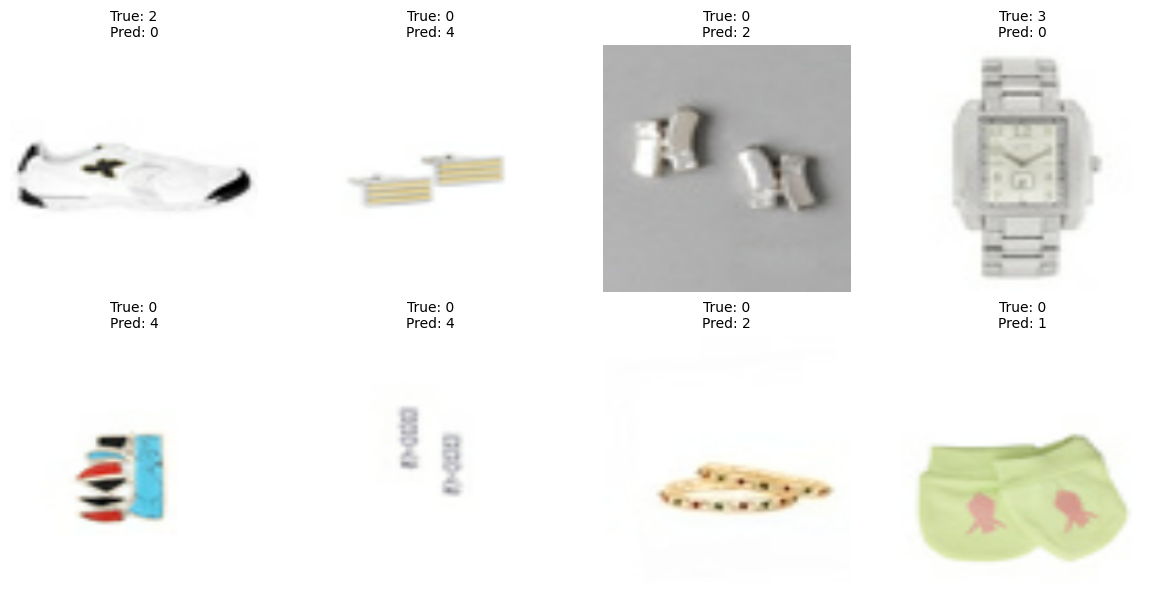

In [15]:
import matplotlib.pyplot as plt

# Find misclassified indices for MobileNetV2 on the full test set
mis_idx_mnet = np.where(y_pred_mnet != y_test_full)[0]
print("Number of misclassified test examples (MobileNetV2):", len(mis_idx_mnet))

num_to_show = min(8, len(mis_idx_mnet))

plt.figure(figsize=(12, 6))
rows, cols = 2, 4

for i, idx in enumerate(mis_idx_mnet[:num_to_show]):
    plt.subplot(rows, cols, i + 1)

    # Convert to uint8 and show
    img = X_test_full[idx].astype("uint8")
    plt.imshow(img)
    plt.axis("off")

    true_label = class_names[y_test_full[idx]]
    pred_label = class_names[y_pred_mnet[idx]]

    # Split title into two lines for readability
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

The visualization above shows eight misclassified examples.  
The labels appear as numbers (e.g., True: 0, Pred: 4) because the dataset internally uses class indices 0–5. In my project, these indices map to the actual category names defined in `CLASS_NAMES`, so a prediction like “True: 0 → Pred: 4” corresponds to:

True class: Accessories  
Predicted class: Personal Care


The baseline CNN and AutoKeras subset model were mainly for comparison, not for deployment.
Visualizing the MobileNetV2 mistakes is more insightful because it is the model I would actually use in a real application

### 14. Web App for Image Upload + Prediction

I wrapped the best AutoKeras model into a Gradio web app.  
This cell loads `autokeras_best_colab.keras` and exposes a simple UI where I (or the TA) can:

- upload any product image,
- run it through the trained AutoKeras classifier, and
- see the **top-3 predicted categories** with their probabilities.

Internally the model still uses the same 0–5 label indices, but in the app I map them back to the human-readable classes:

0 → Accessories  
1 → Apparel  
2 → Footwear  
3 → Free Items  
4 → Personal Care  
5 → Sporting Goods  

This makes it easy to sanity-check predictions visually and is also a nice way to show the project as a small end-to-end product rather than just a notebook.




In [16]:
# --- Gradio demo: Fashion Product Image Classifier (AutoKeras model) ---

!pip install -q gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# 1) Load the best AutoKeras model saved earlier
MODEL_PATH = "models/autokeras_best_colab.keras"
best_model = tf.keras.models.load_model(MODEL_PATH, compile=False)

IMG_SIZE = (224, 224)

# 2) Class names (match label indices 0–5 in the TSV files)
CLASS_NAMES = [
    "Accessories",     # 0
    "Apparel",         # 1
    "Footwear",        # 2
    "Free Items",      # 3
    "Personal Care",   # 4
    "Sporting Goods",  # 5
]

num_classes = best_model.output_shape[-1]
print("Model output classes:", num_classes)

assert num_classes == len(CLASS_NAMES), (
    f"Model has {num_classes} output units but CLASS_NAMES has "
    f"{len(CLASS_NAMES)} entries. Please edit CLASS_NAMES to match."
)


def predict_image(img: Image.Image):
    """Preprocess input image and return softmax probabilities over 6 classes."""
    # Convert to RGB and resize to the training resolution
    img = img.convert("RGB")
    img = img.resize(IMG_SIZE)

    # AutoKeras model already has CastToFloat32 + Normalization inside,
    # so I just pass raw pixel values as float32.
    x = np.array(img, dtype="float32")
    x = np.expand_dims(x, axis=0)  # (1, 224, 224, 3)

    # Predict with the AutoKeras model
    probs = best_model.predict(x, verbose=0)[0]  # shape: (num_classes,)
    probs = probs / probs.sum()  # safety re-normalization

    # Map each class index to a human-readable label
    return {CLASS_NAMES[i]: float(probs[i]) for i in range(num_classes)}


demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload product image"),
    outputs=gr.Label(num_top_classes=3, label="Top-3 predicted classes"),
    title="Fashion Product Image Classifier (AutoKeras)",
    description=(
        "Interactive demo of the AutoKeras CNN trained on 6 fashion categories: "
        "Accessories, Apparel, Footwear, Free Items, Personal Care, and Sporting Goods."
    ),
)

demo.launch(share=False)

Model output classes: 6
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>